In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
from tqdm import tqdm

In [2]:
class PineappleSeller(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.profit = 0
        self.q_table = np.zeros((1, 201))  # Q-table (prices from 9,000 to 11,000 in increments of 10)
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.99  # Discount factor
        self.epsilon = 0.9  # Exploration rate

    def set_price(self):
        if random.random() < self.epsilon:
            action = random.randint(0, 200)
        else:
            action = np.argmax(self.q_table[0])
        return action * 10 + 9000 

    def update_strategy(self, reward, old_action, new_action):
        self.profit += reward 
        self.q_table[0, old_action] += self.alpha * (reward + self.gamma * self.q_table[0, new_action] - self.q_table[0, old_action])

In [3]:
class PineappleMarket(Model):
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.lowest_offers = []
        self.average_lowest_offer = 0
        self.max_lowest_offers = 0
        self.datacollector = DataCollector(
            {
                "Average_Price": lambda m: np.mean([agent.set_price() for agent in m.schedule.agents]),
                "Average_Lowest_Price": lambda m: m.average_lowest_offer,
                "Exploration_Count": lambda m: sum([1 for agent in m.schedule.agents if random.random() < agent.epsilon]),
            }
        )
        
        for i in range(num_agents):
            a = PineappleSeller(i, self)
            self.schedule.add(a)

    def get_highest_profit_agent(self):
        return max(self.schedule.agents, key=lambda a: a.profit)
    
    def run_one_round(self):
        self.datacollector.collect(self)
        offers = []
        for agent in self.schedule.agents:
            offer = agent.set_price()
            offers.append((offer, agent))
        return offers

    def calculate_lowest_offers(self, offers):
        sorted_offers = sorted(offers, key=lambda x: x[0])
        half_size = len(sorted_offers) // 2
        self.lowest_offers = sorted_offers[:half_size]
        self.average_lowest_offer = sum(offer for offer, _ in self.lowest_offers) / len(self.lowest_offers)
        self.max_lowest_offers = self.lowest_offers[-1][0]

    def update_agents(self):
        for offer, agent in self.lowest_offers:
            reward = 0
            if offer <= self.max_lowest_offers:
                reward = offer - self.average_lowest_offer
            old_action = (offer - 9000) // 10 
            new_action = np.argmax(agent.q_table[0])  
            agent.update_strategy(reward, old_action, new_action)
            agent.epsilon *= 0.995



In [4]:
# Set number of agents and rounds
num_agents = 3000
num_rounds = 10000

# Create market model
market = PineappleMarket(num_agents)

# Run simulation
for i in tqdm(range(num_rounds)):
    offers = market.run_one_round()
    market.calculate_lowest_offers(offers)
    market.update_agents()

100%|█████████████████████████████████████| 10000/10000 [04:20<00:00, 38.40it/s]


In [5]:
results = market.datacollector.get_model_vars_dataframe()

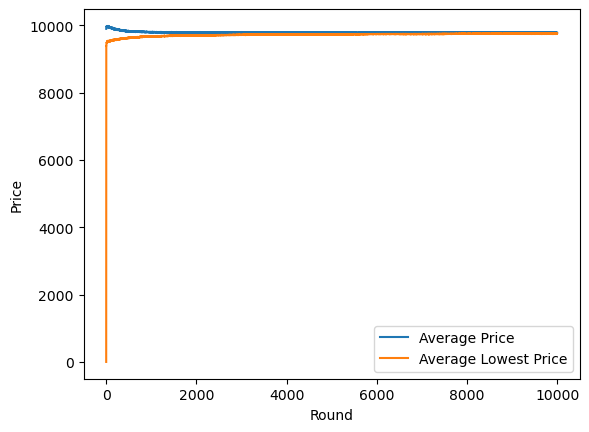

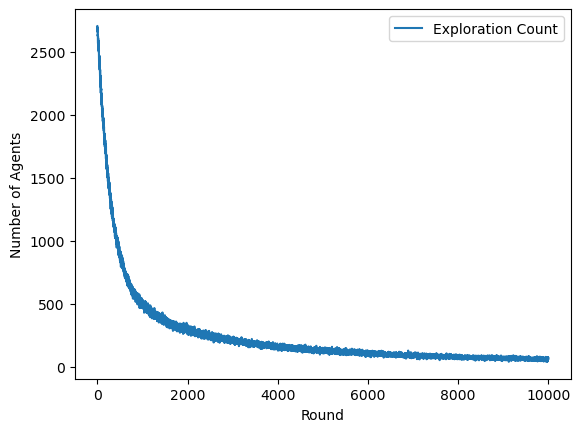

       Average_Price  Average_Lowest_Price  Exploration_Count
count   10000.000000          10000.000000        10000.00000
mean     9795.479719           9716.329977          251.12860
std        22.306184            106.183196          356.28309
min      9779.276667              0.000000           41.00000
25%      9788.295833           9708.083333           86.00000
50%      9790.523333           9732.090000          131.00000
75%      9792.950000           9743.355000          246.00000
max      9981.166667           9755.366667         2704.00000


In [6]:
import matplotlib.pyplot as plt

# Plot average price and average lowest price over time
plt.figure()
plt.plot(results["Average_Price"], label="Average Price")
plt.plot(results["Average_Lowest_Price"], label="Average Lowest Price")
plt.xlabel("Round")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot exploration count over time
plt.figure()
plt.plot(results["Exploration_Count"], label="Exploration Count")
plt.xlabel("Round")
plt.ylabel("Number of Agents")
plt.legend()
plt.show()

# Compute summary statistics
print(results.describe())

In [7]:
# Find agent with the highest profit
highest_profit_agent = market.get_highest_profit_agent()
avg_profit = highest_profit_agent.profit / num_rounds
print(f"Agent {highest_profit_agent.unique_id} has the average profit with {avg_profit} SeaShells / crate.")

best_price_action = np.argmax(highest_profit_agent.q_table[0])
best_price = best_price_action * 10 + 9000
print(f"Agent {highest_profit_agent.unique_id}'s most likely pricing decision: {best_price} SeaShells / crate")

Agent 490 has the average profit with 36.852022666666876 SeaShells / crate.
Agent 490's most likely pricing decision: 9760 SeaShells / crate
